# Subject model in tensorflow

Author: Krzystzof Rusek, AGH University of Science and Technology


In [ ]:
!pip install tensorflow_probability

In [1]:
import numpy as np
import numpy.random as rn
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

I assume a simple user models the same as in Lucjan's simulation [Confidence Interval Simulation](https://colab.research.google.com/drive/1h-8hCWy_VWBjBQ2V5Nk5BUWN7g-0ApOp#scrollTo=6qBhGj1PBTq4):
$o_{ij} = \psi_j + \Delta_i + \epsilon_j$

Where $\psi_j \sim U(1-5)$, i.e. it is from uniform distribution. $\Delta_i \sim N(0,b)$, i.e. it is from normal distribution with mean 0 and $b$ is such that the total variance of a single PVS is constant. $\epsilon \sim N(0,a_j)$ so variance is related to PVS but not user, just for simplicity. $a_j$ is driven from Gamma distribution with some parameters. What we know is that the total standard deviation related to specific PVS should be around 0.7-0.8 (Kjell at call at May, 7, 2018). 0.75 will be the mean but distribution makes it possible to have different errors for different cases.

# EQEG Plot

Text(0,0.5,'$\\phi$')

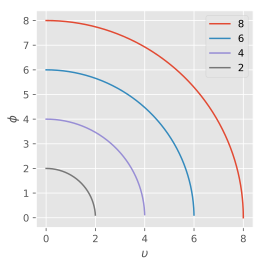

In [50]:
ui=np.linspace(0,8.0,2000)
fii = np.sqrt(8.0**2 - ui**2)
ax=plt.subplot()
ax.plot(ui,fii)
fii = np.sqrt(6.0**2 - ui[ui<6]**2)
ax.plot(ui[ui<6],fii)
fii = np.sqrt(4.0**2 - ui[ui<4]**2)
ax.plot(ui[ui<4],fii)
fii = np.sqrt(2.0**2 - ui[ui<2]**2)
ax.plot(ui[ui<2],fii)
ax.legend([8,6,4,2])
ax.set_aspect(1.0)
ax.set_xlabel(r'$\upsilon$')
ax.set_ylabel(r'$\phi$')

In [44]:
norm(6,1).pdf(4)

0.05399096651318806

Text(0,0.5,'$\\phi$')

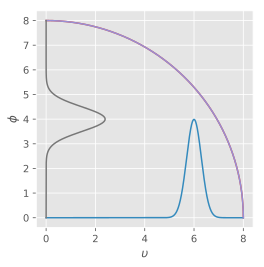

In [51]:
from scipy.stats import norm
ui=np.linspace(0,8.0,2000)
fii = np.sqrt(8.0**2 - ui**2)
ax=plt.subplot()
ax.plot(ui,fii)
ax.plot(ui,3*norm(6,0.3).pdf(ui))
ax.plot(ui,fii)
ax.plot(3*norm(4,0.5).pdf(ui),ui)

ax.set_aspect(1.0)
ax.set_xlabel(r'$\upsilon$')
ax.set_ylabel(r'$\phi$')

# Notation
https://docs.google.com/document/d/1o7nD2ztvlrhyTAB2eocb92OY2egDBjvrh-pE-zo32tQ/edit

$$U_{ij}=\psi_{j} + \Delta_i + \upsilon_i X + \phi_{j} Y$$

$$X,Y \sim N(0,1)%0$$

## Priors

$\Delta_i \sim N(0,b)$ 

$\psi_j \sim U(1-5)$ 

$\upsilon \sim Gamm(\alpha,\beta)$

$\phi \sim Gamm(\alpha,\beta)$

## Multiple solutions 

According to Jing, the ambiguous solution can be avoided by setting priors on parameters. All we need is to have $\upsilon$ and $\phi$  coming from different distributions

By learning just a MAP, we can avoid MCMC methods and use just an optimization.
For further information check the original document by Jing at the link [Setting constraints to make MLE have single optimal solution](https://docs.google.com/document/d/1QqViBmGDm3Si0hPxH4yXGxn9QjO-ZhIJkURNfSrKcK0/edit)

# MAP Estimator

$$P(\theta|d)=\frac{P(d ,\theta )}{P(d)}=\frac{P(d |\theta ) P(\theta)}{P(d)}$$

MAP estimator finds $$ \hat \theta = argmax_\theta   P(\theta|d)$$.

Going to log probs we have ($P(d)$ is marginalized over $\theta$ and can be ommited):
$$
\log P(\theta|d) = \log P(d |\theta ) + \log P(\theta) - \log P(d)
$$

This is just loglikelihood $ll=\log P(d |\theta )$ plus regularization given by log prior $\log P(\theta)$.

If we assume 

1. $\upsilon \sim Gamm(\alpha_1,\beta_1)$
1. $\phi \sim Gamm(\alpha_2,\beta_2)$

the posterior distribution is given by ([Gamma log-likelihood](https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation))

$$
\log P(\theta|d) = ll + I(\alpha_1-1)\overline{\log(\upsilon_i)} -I \frac{\bar \upsilon_i}{\beta_1} + J (\alpha_2-1)\overline{\log(\phi_j)} -J \frac{\bar \phi_j}{\beta_2} + \ldots
$$

We know that maximum of $ll$ is not unique under transformations..., however, log prior does not have such symmetry.
In other words, the internal degree of freedom in log likelihood is fixed by prior assumptions about parameters that serve as constraints.

# Notes

1. Prior improve estimation
1. Estimating continous model from quantized distribution is the most robus, $\Delta$ is biased
1. Hand coded log joint probability, `tfp.edward2.make_log_joint` alows for infering continous score
1. Full Bayess is just one step ahead: MCMC, or StochasticGradientLangevinDynamics
1. $\infty$ in loss, but converges !


## TODO

1. [x] ~~Test various optimizers~~
1. [ ] Proper multinomial distribution for test results (hancoded mapping for continous score)
1. [x] ~~Hack Optimizer for `tf.float64`~~
1. [x] ~~Move this to github~~

# Generative model

The code uses Edwart2 probabilistic programming language from [tensorflow_probability](https://github.com/tensorflow/probability) package

Let us now use the generative code for inference with  $\Delta$,  $\psi$ ,$\upsilon$ and $\phi$ as variables


* Distribution of $O_{ij}$ is quantized normal implemeted using  ```tfp.edward2```
* MLE is obtained by minimizing negative log_prob.
* Initial condition from moments estimators
* MAP is just MLE with prior loglik as regularization 

# Bayesian estimator

This is a full Bayesian approach to parameter estimation


In [122]:
nPVS = 160 # number of PVSs
nSub = 24 # number of Subjects

std = 0.75 # it is standard deviation for typical PVS
alpha = 30.0 # it is parameter of the gamma distribution from which the variances are generated 
b = 0.3 # standard deviation for delta distribution


def make_prior():
    delta_prior = tfp.distributions.Normal(loc=np.float64(0.0),scale=np.float64(0.3) )
    psi_prior = tfp.distributions.Uniform(low=np.float64(1.0),
                                    high=np.float64(5.0) )
    #the same for fi
    upsilon_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))

    fi_prior = tfp.distributions.Gamma(
        concentration=np.float64(alpha),
        rate=np.float64(alpha/np.sqrt(0.5*(std**2 - b**2))))
    return delta_prior,psi_prior,upsilon_prior,fi_prior

# def make_prior():
#     delta_prior = tfp.distributions.Normal(loc=np.float64(0.0),scale=np.float64(0.3) )
#     psi_prior = tfp.distributions.Uniform(low=np.float64(1.0),
#                                           high=np.float64(5.0) )

    
#     #the same for fi
#     upsilon_prior = tfp.distributions.Exponential(rate=np.float64(10))

#     fi_prior = tfp.distributions.Exponential(rate=np.float64(10))
#     return delta_prior,psi_prior,upsilon_prior,fi_prior


def make_model(loc, scale):
    O = tfp.distributions.QuantizedDistribution(
        distribution=tfp.distributions.TransformedDistribution(
            distribution=tfp.distributions.Normal(loc=loc, scale=scale),
            bijector=tfp.bijectors.AffineScalar(shift=np.float64(-0.5))),
        low=np.float64(1.0),
        high=np.float64(5.0))
    
    #O = tfp.distributions.Normal(loc=loc,scale=scale)
    return O

def make_sample():
  
    delta_prior,psi_prior,upsilon_prior,fi_prior = make_prior()
    
    delta = delta_prior.sample([1,nSub])
    psi = psi_prior.sample([nPVS,1])
    
    upsilon = upsilon_prior.sample((1,nSub))
    fi = fi_prior.sample((nPVS,1))
    
    loc = delta + psi 
    
    scale = tf.sqrt(upsilon**2 + fi**2 )

    O = make_model(loc, scale)
    return delta,psi,upsilon,fi,O.sample()

def log_joint(delta, psi, upsilon, fi,o,prior=True):
    delta_prior,psi_prior,upsilon_prior,fi_prior = make_prior()
    
    loc = delta + psi 
    scale = tf.sqrt(upsilon**2 + fi**2 )
    
    O = make_model(loc, scale)

    prior_log_prob = tf.reduce_sum(delta_prior.log_prob(delta)) + \
        tf.reduce_sum(psi_prior.log_prob(psi)) + \
        tf.reduce_sum(upsilon_prior.log_prob(upsilon)) + \
        tf.reduce_sum(fi_prior.copy().log_prob(fi)) 
    
    loglik = tf.reduce_sum(O.log_prob(o))
    ret = loglik + prior_log_prob if prior else loglik
    return ret

def make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat):
    fig,ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10,10)

    ax[0,0].scatter(psi,psi_hat)
    ax[0,0].plot([1,5],[1,5],'k')
    ax[0,0].set_xlabel('True score')
    ax[0,0].set_ylabel('Recovered score')

    ax[0,1].scatter(delta,delta_hat)
    ax[0,1].plot([-1,1.3],[-1,1.3],'k')
    ax[0,1].set_xlabel('True bias')
    ax[0,1].set_ylabel('Recovered bias')

    ax[1,0].scatter(fi,fi_hat)
    ax[1,0].plot([0.2,0.8],[0.2,0.8],'k')
    ax[1,0].set_xlabel('True std')
    ax[1,0].set_ylabel('Recovered std')

    ax[1,1].scatter(upsilon,upsilon_hat)
    ax[1,1].plot([0.2,0.8],[0.2,0.8],'k')
    ax[1,1].set_xlabel('True upsilon')
    ax[1,1].set_ylabel('Recovered upsilon')    
    
g = tf.Graph()
with g.as_default():
    delta,psi,upsilon,fi,o = make_sample()
    log_prob = log_joint(delta,psi,upsilon,fi,o)
    
with tf.Session(graph=g) as sess:
    print(sess.run([o,log_prob]))


[array([[3., 4., 4., ..., 1., 3., 3.],
       [1., 2., 1., ..., 2., 1., 2.],
       [4., 4., 5., ..., 4., 4., 5.],
       ...,
       [3., 3., 4., ..., 3., 3., 1.],
       [5., 5., 5., ..., 5., 4., 5.],
       [3., 4., 3., ..., 3., 3., 3.]]), -3772.319006391747]


## Groud truth
Lets dra some samples an try to estimate parameters

In [230]:
g = tf.Graph()
with g.as_default():
    s = make_sample()
with tf.Session(graph=g) as sess:
    delta,psi,upsilon,fi,o = sess.run(s)



## MLE

0 2.451942840312378
300 1.4407932211061383
600 1.2785866590503319
900 1.1778019996035467
1200 1.1189254848477268
1500 1.0820018906385704
1800 1.0567820021573884
2100 1.037913341313338
2400 1.0229393591596263
2700 1.0106486597833901
3000 1.000333473795648
3300 0.9915732944295595
3600 0.9841779488572164
3900 0.9779232454105778
4200 0.9724754784333699
4500 0.9675701455220039
4800 0.9630961490337353
5100 0.9589709615638149
5400 0.9550766846114634
5700 0.9513375300376805
6000 0.9477723390480475
6300 0.9444904370000219
6600 0.9416091716991484
6900 0.9391745469350833
7200 0.93706243889882
7500 0.9354075470876495
7800 0.934153179973417
8100 0.9331435883856732
8400 0.9323959591775292
8700 0.9313477205997867
9000 0.9306097689519675
9300 0.9300586963727235
9600 0.929493091815918
9900 0.9289444492610196


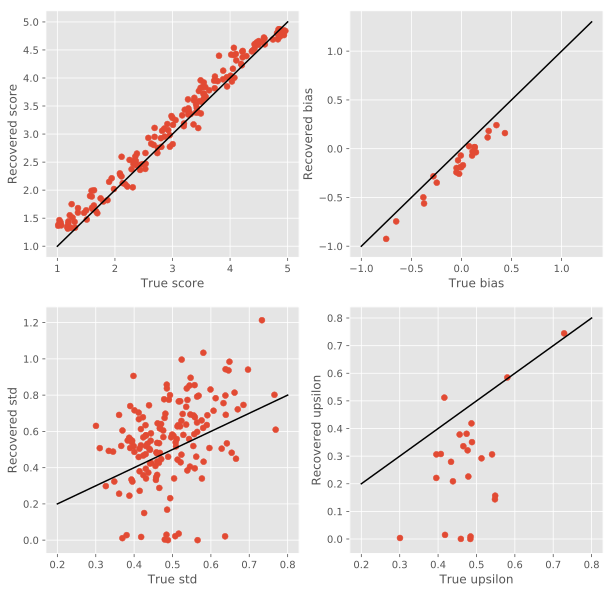

In [231]:
g = tf.Graph()
with g.as_default():
    s = make_sample()
with tf.Session(graph=g) as sess:
    delta,psi,upsilon,fi,o = sess.run(s)

g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    tf_delta = tf.Variable(delta_s)
    tf_psi_var = tf.Variable((psi_s-np.float64(1.0))/np.float64(4.0))
    tf_psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(tf_psi_var)

    
    tf_upsilon_sqr = tf.Variable(tf.sqrt(upsilon_s))
    tf_upsilon = tf_upsilon_sqr**2
    
    tf_fi_sqr = tf.Variable(tf.sqrt(fi_s))
    tf_fi = tf_fi_sqr**2
    
    log_prob = log_joint(tf_delta,tf_psi,tf_upsilon,tf_fi,o,prior=False)
    loss = -log_prob/(nSub*nPVS)
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.02, epsilon=0.01).minimize(loss)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _,np_loss = sess.run([train_op,loss])
        if i % 300 ==0:
            print(i,np_loss)

    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

### MAP

0 2.5475329755230116
500 1.326090782473005
1000 1.1085852171158745
1500 1.018633734189166
2000 0.9839906975441787
2500 0.9687675801893373
3000 0.9609473473121285
3500 0.9563837065222539
4000 0.9534542170406602
4500 0.9514361354779158
5000 0.9499698617557422
5500 0.948859856073108
6000 0.9479919756671809
6500 0.9472956421542839
7000 0.9467250812017023
7500 0.9462493893780797
8000 0.9458469798650794
8500 0.9455023287573022
9000 0.9452039902539142
9500 0.9449433418554305


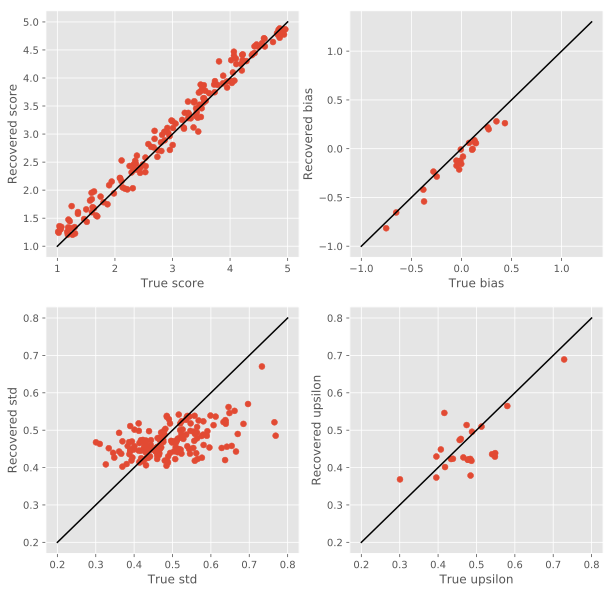

In [232]:

g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    tf_delta = tf.Variable(delta_s)
    tf_psi_var = tf.Variable((psi_s-np.float64(1.0))/np.float64(4.0))
    tf_psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(tf_psi_var)

    
    tf_upsilon_sqr = tf.Variable(tf.log(upsilon_s))
    tf_upsilon = tf.exp(tf_upsilon_sqr)
    
    tf_fi_sqr = tf.Variable(tf.log(fi_s))
    tf_fi = tf.exp(tf_fi_sqr)
    
    log_prob = log_joint(tf_delta,tf_psi,tf_upsilon,tf_fi,o)
    loss = -log_prob/(nSub*nPVS)
    train_op = tf.train.RMSPropOptimizer(learning_rate=0.02, epsilon=0.01).minimize(loss)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _,np_loss = sess.run([train_op,loss])
        if i % 500 ==0:
            print(i,np_loss)

    (delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat, 
     loss_val) = sess.run([tf_delta,tf_psi,tf_upsilon,tf_fi,loss])

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

## MCMC

In [233]:
def target_log_prob_fn(delta_o, psi_o, upsilon_o, fi_o):
    """Unnormalized target density as a function of states."""
    psi = np.float64(1.0) + np.float64(4.0) * tf.nn.sigmoid(psi_o)
    upsilon = tf.exp(upsilon_o)
    fi = tf.exp(fi_o)
    return log_joint(delta_o, psi, upsilon, fi,o)
    
g = tf.Graph()
with g.as_default():
    # random start conditions
    delta_s,psi_s,upsilon_s,fi_s,_ = make_sample()
    
    num_results = 10000
    num_burnin_steps = 3000
    
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            delta_s,
            (psi_s-np.float64(1.0))/np.float64(4.0),
            tf.log(upsilon_s),
            tf.log(fi_s)
        ],
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.01,
            num_leapfrog_steps=3))
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    np_states,acepted = sess.run([states,kernel_results.is_accepted])



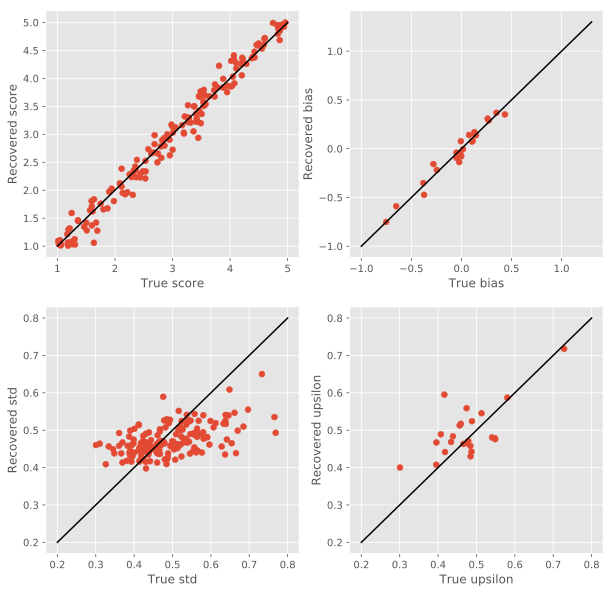

In [247]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

np_states[1] = 1 + 4*sigmoid(np_states[1])

np_states[2] = np.exp(np_states[2])
np_states[3] = np.exp(np_states[3])

(delta_hat, 
     psi_hat, 
     upsilon_hat, 
     fi_hat)=map(lambda x: np.mean(x,axis=0),np_states)

make_plot(psi,psi_hat,delta,delta_hat,fi,fi_hat,upsilon,upsilon_hat)

Text(0,0.5,'$\\hat \\psi$')

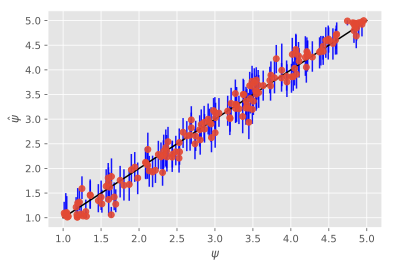

In [267]:
ax = plt.subplot()
err = [psi_hat-np.percentile(np_states[1],q=2.5,axis=0),
      np.percentile(np_states[1],q=97.5,axis=0)-psi_hat]

ax.errorbar(x=psi,y=psi_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([1,5],[1,5],'k')
ax.set_xlabel(r'$\psi$')
ax.set_ylabel(r'$\hat \psi$')


Text(0,0.5,'$\\hat \\delta$')

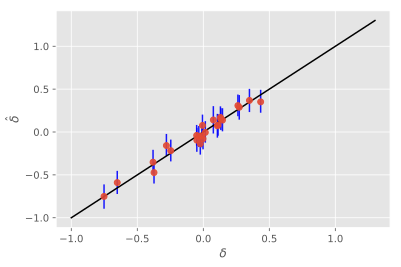

In [268]:
ax = plt.subplot()
err = [delta_hat-np.percentile(np_states[0],q=2.5,axis=0),
      np.percentile(np_states[0],q=97.5,axis=0)-delta_hat]

ax.errorbar(x=delta,y=delta_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([-1,1.3],[-1,1.3],'k')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\hat \delta$')


Text(0,0.5,'$\\hat \\upsilon$')

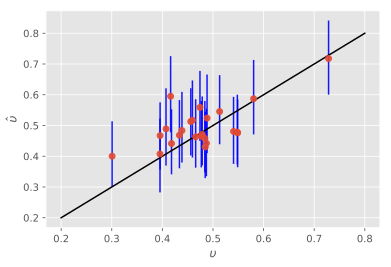

In [263]:
ax = plt.subplot()
err = [upsilon_hat-np.percentile(np_states[2],q=2.5,axis=0),
      np.percentile(np_states[2],q=97.5,axis=0)-upsilon_hat]

ax.errorbar(x=upsilon,y=upsilon_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([0.2,0.8],[0.2,0.8],'k')
ax.set_xlabel(r'$\upsilon$')
ax.set_ylabel(r'$\hat \upsilon$')


Text(0,0.5,'$\\hat \\phi$')

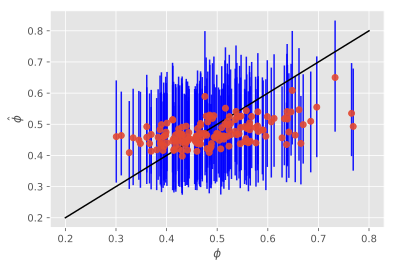

In [262]:
ax = plt.subplot()
err = [fi_hat-np.percentile(np_states[3],q=2.5,axis=0),
      np.percentile(np_states[3],q=97.5,axis=0)-fi_hat]

ax.errorbar(x=fi,y=fi_hat, fmt='o',yerr=err, alpha=0.9,ecolor='b')
ax.plot([0.2,0.8],[0.2,0.8],'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\hat \phi$')
